#### Forecasting Amtrak Ridership using ARIMA model
##### 03-31-2024

dataset source: https://www.kaggle.com/datasets/nirmalnk/amtrak-timeseries

In [17]:
# Import packages
import os
import numpy as np 
import pandas as pd
from pandas import to_datetime 
from matplotlib import pyplot as plt 
import seaborn as sns 
import itertools 
import datetime 
from datetime import datetime 
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline 

# Import ARIMA model packages 
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt 

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression 
from sklearn import linear_model 

# Import Auto ARIMA packages
import pmdarima as pm 
from pmdarima.model_selection import train_test_split


In [18]:
# Import database 
df = pd.read_csv("AmtrakBig_raw.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Month      159 non-null    object
 1   Ridership  159 non-null    int64 
 2   t          159 non-null    int64 
 3   Season     159 non-null    object
dtypes: int64(2), object(2)
memory usage: 5.1+ KB


In [19]:
df.head()

,Month,Ridership,t,Season
0,Jan-91,1709,1,Jan
1,Feb-91,1621,2,Feb
2,Mar-91,1973,3,Mar
3,Apr-91,1812,4,Apr
4,May-91,1975,5,May


##### 1. Data Preparation

In [20]:
# Select t, Ridership only 
df2 = df[['Month', 'Ridership']]

# Convert Month to datetime format 
df2['Month'] = pd.to_datetime(df2['Month'], format='%b-%y')

df2.info()
df2.head(10) #Now we have list of monthly rent from 2015-01 to 2024-02.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Month      159 non-null    datetime64[ns]
 1   Ridership  159 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.6 KB


,Month,Ridership
0,1991-01-01,1709
1,1991-02-01,1621
2,1991-03-01,1973
3,1991-04-01,1812
4,1991-05-01,1975
5,1991-06-01,1862
6,1991-07-01,1940
7,1991-08-01,2013
8,1991-09-01,1596
9,1991-10-01,1725


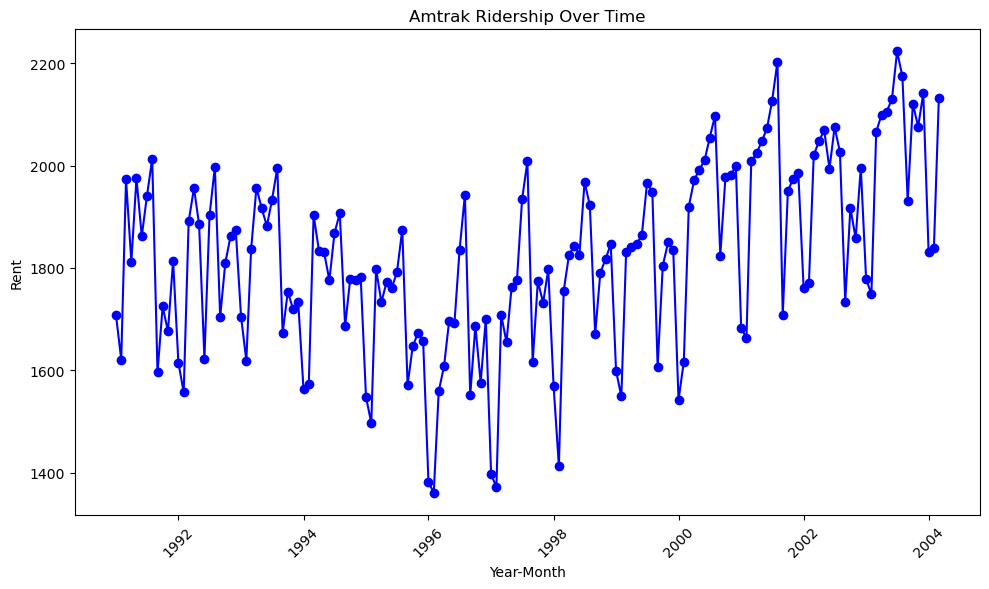

In [21]:
# Plot a line plot using the time series dataset
plt.figure(figsize=(10, 6))  # Set the figure size 
plt.plot(df2['Month'], df2['Ridership'], marker='o', linestyle='-', color='b')  # Plot with markers and a line

plt.title('Amtrak Ridership Over Time')  
plt.xlabel('Year-Month')  
plt.ylabel('Rent')  
plt.xticks(rotation=45)  
plt.tight_layout()

plt.show()  

There are visible patterns that suggest seasonality in the data → Try Seasonal ARIMA here

##### 2. Fit SARIMA model for forecasting

In [22]:
train = df[:-12]
validation = df[-12:]

# Find the best p,d,q combination gives lowest AIC
p = d = q = range(0, 3)  # ranges for ARIMA parameters, 0 - 2
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))] # 12 for 12 months

best_aic = float("inf")
best_params = None
best_seasonal_params = None

for param in itertools.product(p, d, q):
    for seasonal_param in seasonal_pdq:
        try:
            model = SARIMAX(train['Ridership'],
                            order=param,
                            seasonal_order=seasonal_param,
                            enforce_stationarity=False,
                            enforce_invertibility=False)
            results = model.fit(maxiter=200, disp=0)  # Set disp=0 to reduce output verbosity
        except Exception as e:
            print(f"ARIMA{param}x{seasonal_param} - AIC: None - Exception: {e}")
            continue  # Continue to the next iteration

        # Check if the current model AIC is lower than what we've seen before
        if results.aic < best_aic:
            best_aic = results.aic
            best_params = param
            best_seasonal_params = seasonal_param

# Print out the best parameters and AIC
if best_params is not None:
    print(f"Best SARIMA parameters: {best_params}")
    print(f"Best Seasonal parameters: {best_seasonal_params}")
    print(f"Best AIC: {best_aic}")
else:
    print("No suitable model was found.")


Best SARIMA parameters: (0, 2, 2)
Best Seasonal parameters: (0, 2, 2, 12)
Best AIC: 1070.9745724402078


In [23]:
# Fit the model with the best parameters

best_model = SARIMAX(train['Ridership'],
                     order=best_params,
                     seasonal_order=best_seasonal_params,
                     enforce_stationarity=False,
                     enforce_invertibility=False)
best_model_fit = best_model.fit()

# Summarize the final model
print(best_model_fit.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.01142D+00    |proj g|=  3.62658D-01


 This problem is unconstrained.



At iterate    5    f=  3.83154D+00    |proj g|=  4.52631D-02

At iterate   10    f=  3.82489D+00    |proj g|=  3.12027D-02

At iterate   15    f=  3.82468D+00    |proj g|=  2.04664D-02

At iterate   20    f=  3.82404D+00    |proj g|=  3.80287D-02

At iterate   25    f=  3.80318D+00    |proj g|=  9.89519D-02

At iterate   30    f=  3.77963D+00    |proj g|=  1.54422D-01

At iterate   35    f=  3.61056D+00    |proj g|=  1.44119D-01

At iterate   40    f=  3.60893D+00    |proj g|=  5.26169D-03

At iterate   45    f=  3.60877D+00    |proj g|=  1.56348D-03

At iterate   50    f=  3.60876D+00    |proj g|=  2.01269D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

In [24]:
# Generate forecasts for the validation period
forecast_result = best_model_fit.get_forecast(steps=12)

# Get the forecast values
forecasted_values = forecast_result.predicted_mean

# Get the confidence intervals of the forecasts
conf_int = forecast_result.conf_int(alpha=0.05)
print(conf_int)

     lower Ridership  upper Ridership
147      1963.971351      2216.610247
148      1957.845354      2252.295901
149      1925.495679      2258.066453
150      1967.115537      2335.264383
151      1933.739306      2335.599748
152      1566.409452      2000.550031
153      1764.014667      2229.301953
154      1727.177678      2222.692105
155      1791.448031      2316.428721
156      1531.439649      2085.244282
157      1513.992008      2095.739792
158      1798.895113      2408.945463


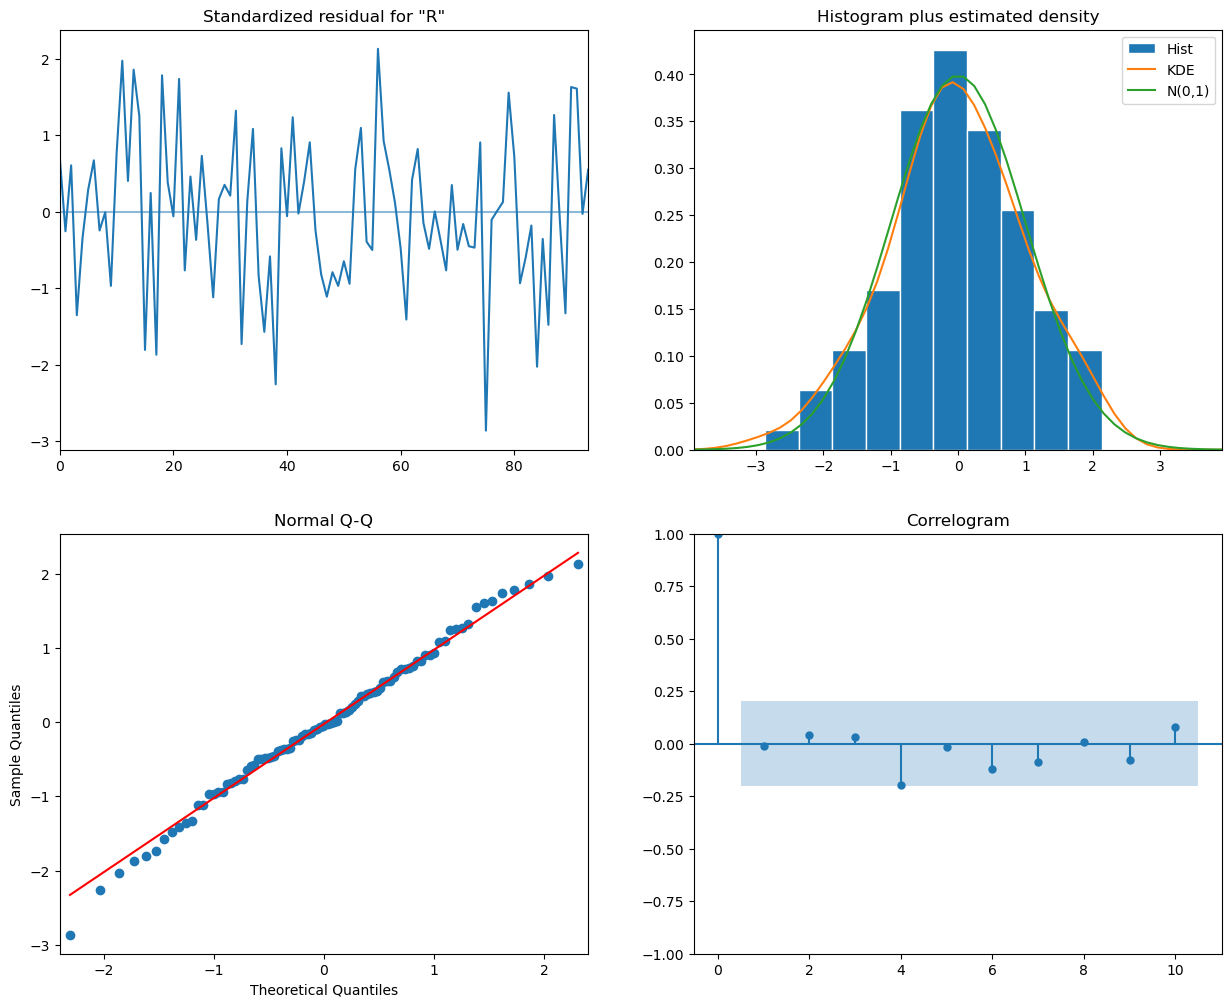

In [25]:
best_model_fit.plot_diagnostics(figsize=(15, 12))
plt.show()

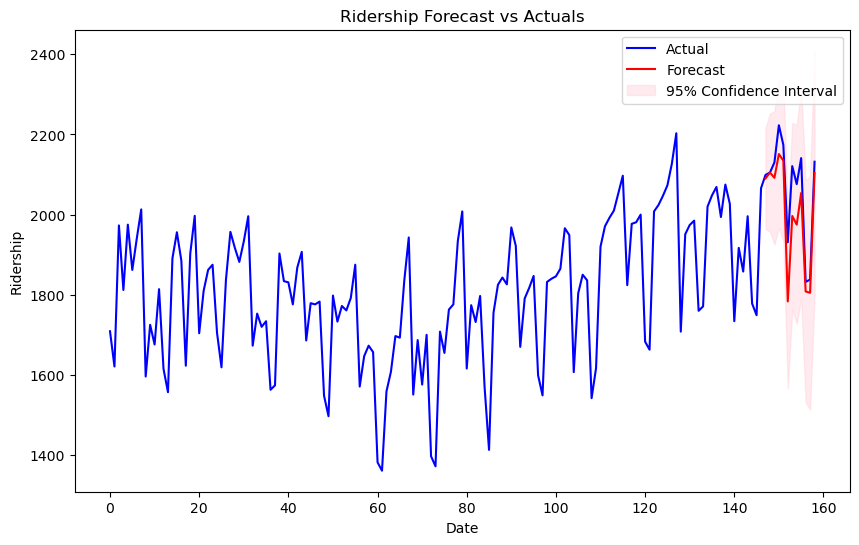

In [26]:
# Visualize the forecasted values vs. actial values 

# Plot the actual data
plt.figure(figsize=(10, 6))
plt.plot(df['Ridership'], label='Actual', color='blue')

# Plot the forecasted values
plt.plot(validation.index, forecasted_values, label='Forecast', color='red')

# Plot the confidence interval as a shaded area around the line
plt.fill_between(validation.index,
                 conf_int.iloc[:, 0], conf_int.iloc[:, 1],
                 color='pink', alpha=0.3, label='95% Confidence Interval')

plt.title('Ridership Forecast vs Actuals')
plt.xlabel('Date')
plt.ylabel('Ridership')
plt.legend()
plt.show()


In [27]:
# Calculate MAE and RMSE and for quantitative evaluation and display
mae = mean_absolute_error(validation['Ridership'], forecasted_values)
rmse = np.sqrt(mean_squared_error(validation['Ridership'], forecasted_values))

print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {rmse}')

Mean Absolute Error: 58.58331692583587
Root Mean Squared Error: 73.99499796247932


The forecast appears to capture some of the variability in the ridership data

##### 3. ARIMA model

In [28]:
train = df[:-12]
validation = df[-12:]

# Find the best p, d, q combination for the lowest AIC
p = d = q = range(0, 3)  # ranges for ARIMA parameters, 0 - 2

best_aic = float("inf")
best_params = None

for param in itertools.product(p, d, q):
    try:
        # ARIMA model does not use seasonal_order, so we exclude it
        model = ARIMA(train['Ridership'], order=param)
        results = model.fit()  
        
        # Check if the current model AIC is lower than what we've seen before
        if results.aic < best_aic:
            best_aic = results.aic
            best_params = param
            
    except Exception as e:
        print(f"ARIMA{param} - AIC: None - Exception: {e}")
        continue  # Continue to the next iteration

# Print out the best parameters and AIC
if best_params is not None:
    print(f"Best ARIMA parameters: {best_params}")
    print(f"Best AIC: {best_aic}")
else:
    print("No suitable ARIMA model was found.")


Best ARIMA parameters: (2, 1, 2)
Best AIC: 1843.7717475999127


In [29]:
# Fit the model with the best parameters

best_model = ARIMA(train['Ridership'],
                     order=best_params)
best_model_fit = best_model.fit()

# Summarize the final model
print(best_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:              Ridership   No. Observations:                  147
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -916.886
Date:                Mon, 01 Apr 2024   AIC                           1843.772
Time:                        10:46:43   BIC                           1858.690
Sample:                             0   HQIC                          1849.833
                                - 147                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0063      0.010     -0.610      0.542      -0.026       0.014
ar.L2         -0.9930      0.007   -133.316      0.000      -1.008      -0.978
ma.L1         -0.1079      0.103     -1.047      0.2

In [30]:
# Generate forecasts for the validation period
forecast_result = best_model_fit.get_forecast(steps=12)

# Get the forecast values
forecasted_values = forecast_result.predicted_mean

# Get the confidence intervals of the forecasts
conf_int = forecast_result.conf_int(alpha=0.05)
print(conf_int)

     lower Ridership  upper Ridership
147      1781.259589      2275.730733
148      1510.209043      2170.962141
149      1483.340029      2274.679887
150      1599.653563      2531.081436
151      1498.942914      2553.136634
152      1270.391947      2412.066282
153      1270.361240      2492.527112
154      1406.112201      2723.314128
155      1320.408401      2726.844889
156      1105.319128      2578.468979
157      1115.546538      2652.126053
158      1257.441336      2870.634319


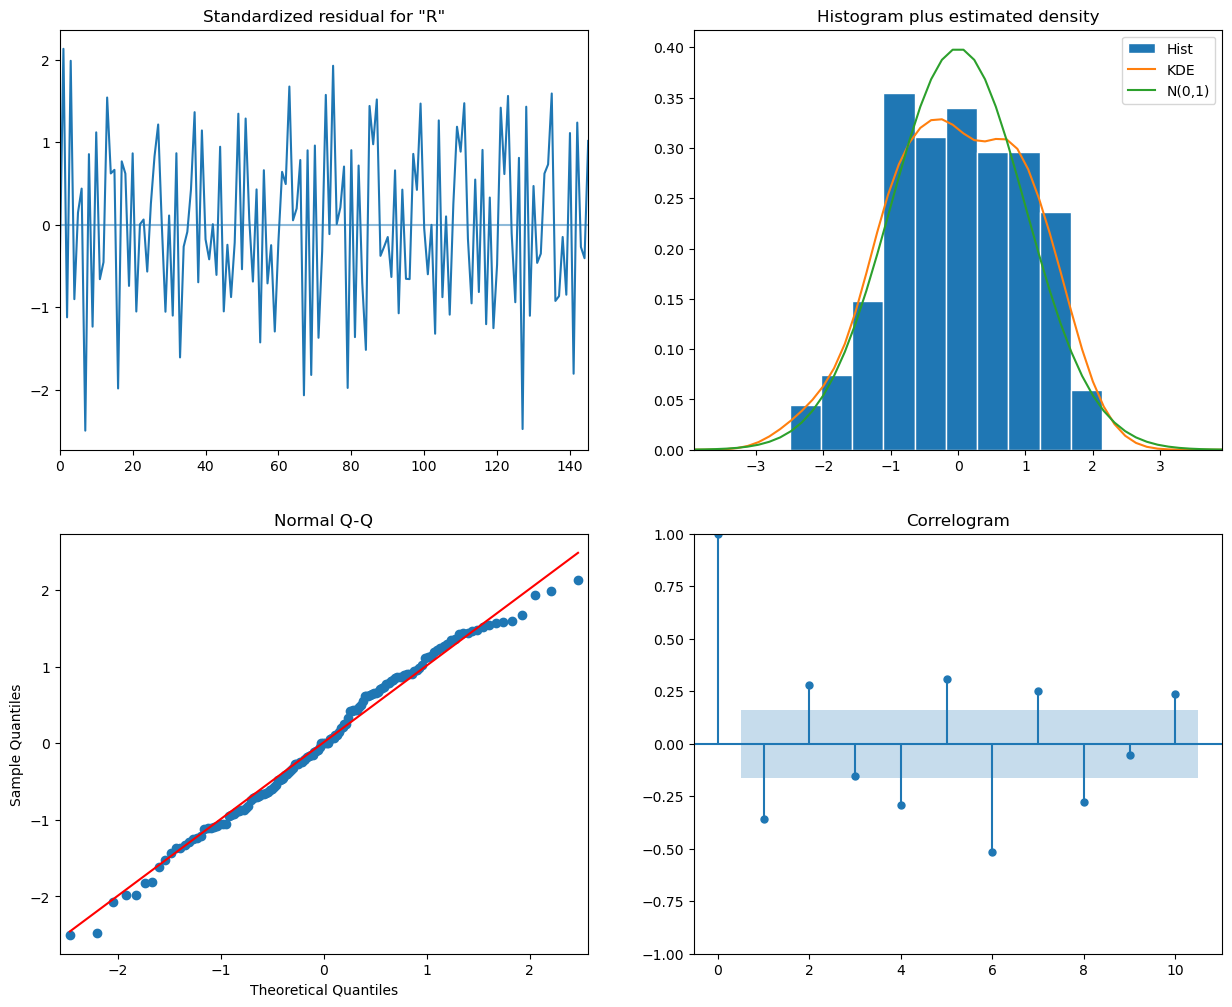

In [31]:
best_model_fit.plot_diagnostics(figsize=(15, 12))
plt.show()


- The residuals do not show obvious patterns over time, which is good.
- The distribution of residuals is approximately normal with slightly heavier tails.
- There is no significant autocorrelation in the residuals, suggesting that the model has captured the time series' autocorrelation structure adequately.

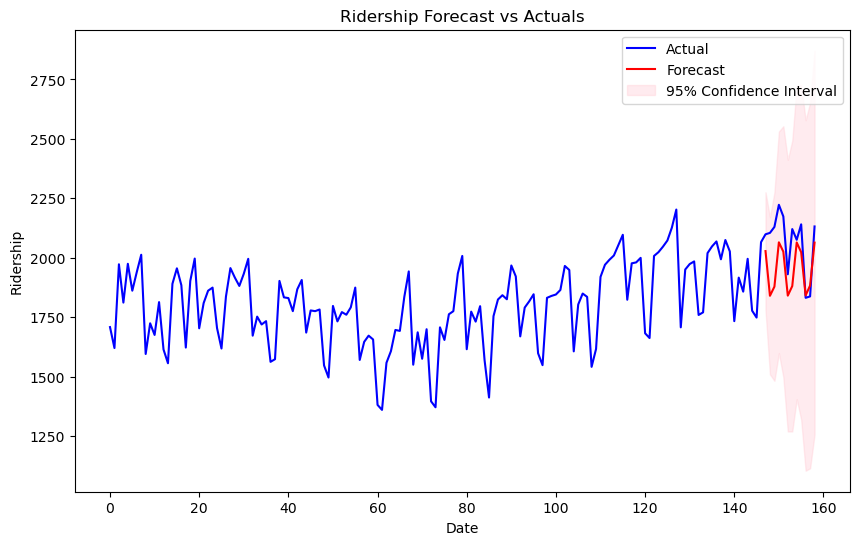

In [32]:
# Visualize the forecasted values vs. actial values 

# Plot the actual data
plt.figure(figsize=(10, 6))
plt.plot(df['Ridership'], label='Actual', color='blue')

# Plot the forecasted values
plt.plot(validation.index, forecasted_values, label='Forecast', color='red')

# Plot the confidence interval as a shaded area around the line
plt.fill_between(validation.index,
                 conf_int.iloc[:, 0], conf_int.iloc[:, 1],
                 color='pink', alpha=0.3, label='95% Confidence Interval')

plt.title('Ridership Forecast vs Actuals')
plt.xlabel('Date')
plt.ylabel('Ridership')
plt.legend()
plt.show()

In [33]:
# Calculate MAE and RMSE and for quantitative evaluation and display
mae = mean_absolute_error(validation['Ridership'], forecasted_values)
rmse = np.sqrt(mean_squared_error(validation['Ridership'], forecasted_values))

print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {rmse}')

Mean Absolute Error: 122.76511976798241
Root Mean Squared Error: 150.21916306314367


**ARIMA model**
- Mean Absolute Error: 122.76511976798241
- Root Mean Squared Error: 150.21916306314367

**SARIMA model**
- Mean Absolute Error: 58.58331692583587
- Root Mean Squared Error: 73.99499796247932

ARIMA model's MAE and RMSE are much greater than those of SARIMA model. Therefore, the SARIMA model, which accounts for both seasonality and non-seasonality components, seems to have a better predictive accuracy for your data than the ARIMA model, which does not account for seasonality.